In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
INPUT_ROOT = Path('./input/gb-credit-default/')
OUTPUT_ROOT = Path('./output/')

#INPUT_ROOT = Path('/kaggle/input/gb-credit-default/')
#OUTPUT_ROOT = Path('/kaggle/output/')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

# Курсовой проект

## Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## 1. Обзор обучающего датасета

Описание данных:
* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
# Загрузка данных

df_train = pd.read_csv(INPUT_ROOT / 'train.csv')
df_test = pd.read_csv(INPUT_ROOT / 'test.csv')
df_submit = pd.read_csv(INPUT_ROOT / 'sample_submission.csv')

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

TARGET_NAME = 'Credit Default'

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

В среди данных мы видим 12 числовых признака, 4 категориальных и целевая переменная

**Обзор целевой переменной**

0    5387
1    2113
Name: Credit Default, dtype: int64

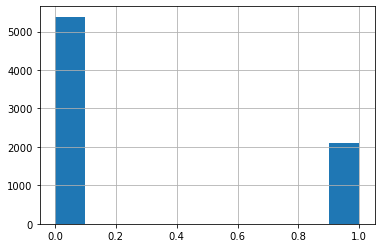

In [5]:
df_train['Credit Default'].hist()
df_train['Credit Default'].value_counts()

Мы видим явный дисбаланс классов.

Всего 28% случаев 1-го класса, и 72% случаев нулевого.

Учитывая, что для нас важно предсказание именно 1-го класса - это существенная проблема.

При обучении мы воспользуемся одним из методов балансировки классов.

**Обзор числовых параметров**

In [6]:
NUM_FEATURES_NAME = [
    'Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
    'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies',
    'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'
]

df_train[NUM_FEATURES_NAME].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BF91A30>,
      dtype=object)

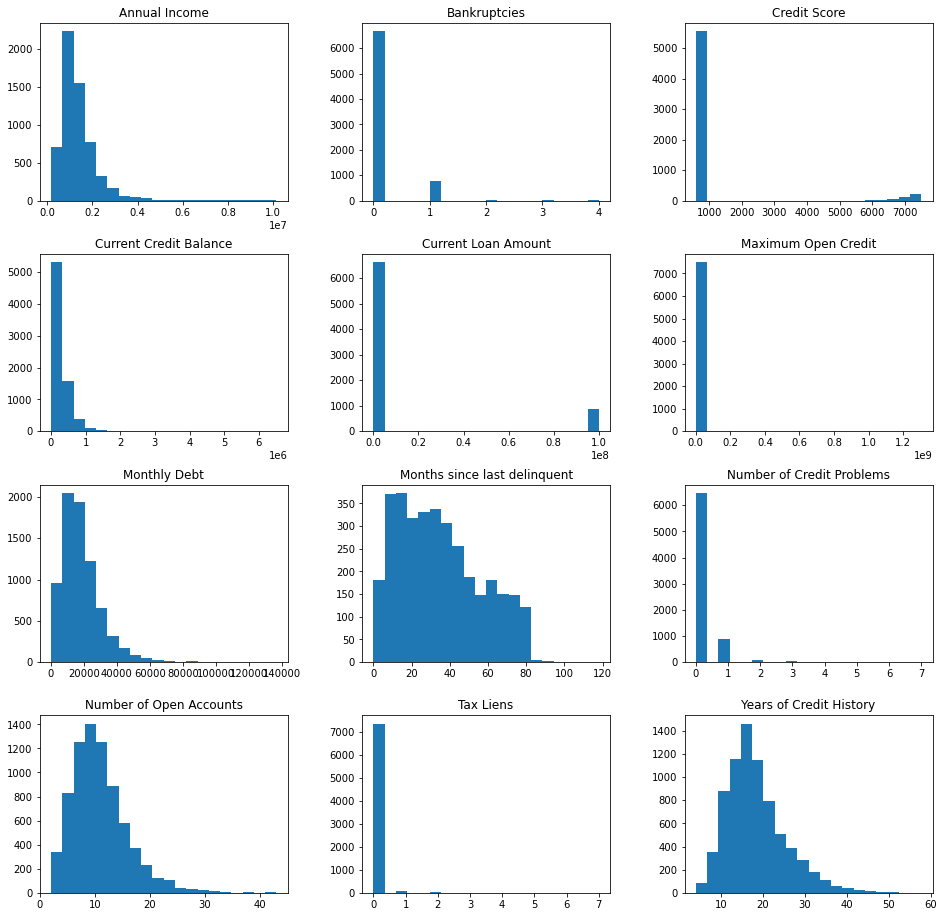

In [7]:
df_train[NUM_FEATURES_NAME].hist(figsize=(16,16), bins=20, grid=False)

Из графиков видно, что фичи: 

1) **Tax Liens, Bankruptcies** - их числовой характер не однозначен; 

**Будем рассматривать их как категориальные**

2) **Months since last delinquent** - на распределении видны 2 или даже 3 пика и в то же время мы видим подозрительно мало значений в 0, хотя очевидно, что их должно быть большинство. 

**Что с этим делать - непонятно**

3) **Maximum Open Credit, Current Loan Amount, Credit Score** - имеют необычное распределение, с пиком у нуля и экспоненциальным возрастанием. Скорее всего оно связано с большим числом людей без кредитов.

**Первая идея для фичи - класс тех, кто обратился без кредитов**

4) **Annual Income, Current Credit Balance, Monthly Debt** - графики распределений имеют длинный хвост.

**Будем считать выбросами данные свыше 97%  квантиля и пересчитаем их через модель**

5) **Monthly Debt, Annual Income** - есть схожесть распределения, но их влияние скорее всего глубже при совместном использовании.

**Вторая идея для фичи - отношение ежемесячного дохода к ежемесячному платежу + разность ежемесячного дохода и ежемесячного платежа**

6) **Number of Open Accounts, Years of Credit History** - отличные данные

In [8]:
# числовых фич теперь - 12
NUM_FEATURES_NAME = [
    'Annual Income', 'Number of Open Accounts', 'Years of Credit History',
    'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
    'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'
]

In [9]:
X = df_train.drop(columns=[TARGET_NAME])
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)


df_train = pd.concat([X_train, y_train], axis=1)
df_train_test = pd.concat([X_test, y_test], axis=1)


**Обзор категориальных переменных**

In [10]:
# категориальных - 6
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term','Tax Liens', 'Bankruptcies']

# Метод по переводу фичи в категориальную
def _convertFeatureToCat(df, colName):
    return 'class - ' + df[colName].astype(str)

# Приведение полей
def processNumFeatures(df):
    # переведем 2 фичи в категориальные
    for colName in ['Tax Liens', 'Bankruptcies']:
        df[colName] = _convertFeatureToCat(df, colName)
    return df

df_train = processNumFeatures(df_train)

In [11]:
for featureName in CAT_FEATURE_NAMES:
    print(str(featureName) + '\n\n' + str(df_train[featureName].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    2569
Rent             2212
Own Home          462
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    1622
2 years       496
3 years       445
< 1 year      387
5 years       366
1 year        357
4 years       329
6 years       300
7 years       288
8 years       235
9 years       172
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      4145
other                    444
home improvements        311
business loan             96
buy a car                 72
medical bills             54
major purchase            32
buy house                 24
take a trip               23
small business            18
wedding                    9
moving                     8
educational expenses       7
vacation  

Все признаки имеют ожидаемое распределение, рассмотрим их влияние на таргет:

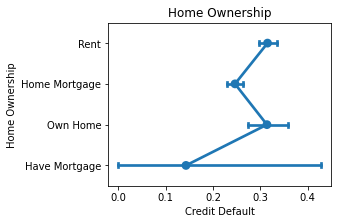

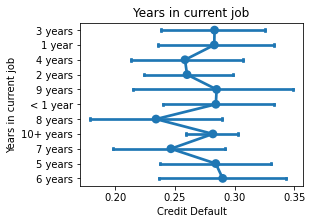

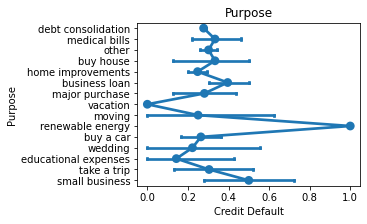

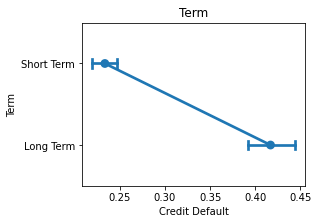

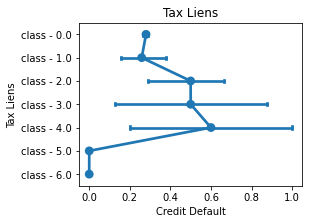

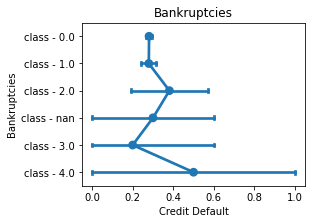

In [12]:
for fn in CAT_FEATURE_NAMES:
    plt.figure(figsize=(4, 3))
    sns.pointplot(x=TARGET_NAME, y=fn, data=df_train.loc[~df_train[fn].isna()], capsize=.1)
    plt.title(fn)
    plt.show()

Для категориальных признаков в основном будем применять метод oneHotEncoding, с небольшими поправками:

1) **Tax Liens** - Сократим число классов до 3-х: {0,1}, {2,3,4,5} и {6,7}.

2) **Purpose** - среди целей есть несколько целей, которые дают худший доверительный интервал (renewable energy, business loan и small business), а также одна цель, которая дает лучший результат по возвратам - educational expenses. Cократим число признаков до 3-х: education, bussines, others.

3) **Term** - отличный разделяющий признак, применим к нему кодирование с упорядочиванием.

In [13]:
# Приведение категориальных полей
def processCatFeatures(df):
    # сократим число классов в Tax Liens
    df['Tax Liens Encoded'] = '2-5'
    df.loc[(df['Tax Liens']=='class - 0.0') | (df['Tax Liens']=='class - 1.0'),'Tax Liens Encoded'] = '0-1'
    df.loc[(df['Tax Liens']=='class - 6.0') | (df['Tax Liens']=='class - 7.0'),'Tax Liens Encoded'] = '6-7'
    
    # сократим число классов в Purpose
    df['Purpose Encoded'] = 'others'
    df.loc[df['Purpose']=='educational expenses','Purpose Encoded'] = 'education'
    df.loc[(df['Purpose']=='renewable energy') | (df['Purpose']=='business loan') | (df['Purpose']=='small business'),'Purpose Encoded'] = 'business'
    
    columnsBefore = df.columns
    
    # упорядочивание для фичи Short Term
    df['Term Encoded'] = 0
    df.loc[df['Term']=='Long Term','Term Encoded'] = 1
    
    # Для остальных oneHotEncoding
    OneHotColumns = ['Home Ownership', 'Years in current job', 'Purpose Encoded', 'Tax Liens Encoded', 'Bankruptcies']
    for columnName in OneHotColumns:
        df = pd.concat([df, pd.get_dummies(df[columnName], prefix=columnName)], axis=1)
    
    return df, list(set(df.columns) - set(columnsBefore))

df_train, newFields = processCatFeatures(df_train)
NUM_FEATURES_NAME = NUM_FEATURES_NAME + newFields
CAT_FEATURE_NAMES = CAT_FEATURE_NAMES + ['Purpose Encoded', 'Tax Liens Encoded']

## 2. Обработка выбросов


В данных не наблюдается большого количества выбросов, поэтому как-то специально обработывать их не будем и обработаем в рамках работы с пропусками.

Заменим все что больше квантиля 97% для колонок Annual Income, Current Credit Balance, Monthly Debt пропусками.

In [14]:
# Метод по обрезке фич по уровню 97%
def _cutFeatureToQuant(df, colName, quantile=0.97):
    df = df.copy()
    threshold = df[colName].quantile(quantile)
    df.loc[df[colName] > threshold, colName] = np.nan
    return df[colName];

# обработка выбросов
def processOutlier(df):
    TO_BIG_VALUES_COLUMNS = ['Annual Income', 'Current Credit Balance', 'Monthly Debt']

    for colName in TO_BIG_VALUES_COLUMNS:
        df[colName] = _cutFeatureToQuant(df, colName, 0.97)
    
    return df

df_train = processOutlier(df_train)

## 3. Обработка пропусков


Рассмотрим сколько у нас пропусков.

In [15]:
df_train.isna().sum()

Home Ownership                       0
Annual Income                     1199
Years in current job               253
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent      2833
Bankruptcies                         0
Purpose                              0
Term                                 0
Current Loan Amount                  0
Current Credit Balance             158
Monthly Debt                       158
Credit Score                      1073
Credit Default                       0
Tax Liens Encoded                    0
Purpose Encoded                      0
Term Encoded                         0
Home Ownership_Have Mortgage         0
Home Ownership_Home Mortgage         0
Home Ownership_Own Home              0
Home Ownership_Rent                  0
Years in current job_1 year          0
Years in current job_10+ 

1) **Years in current job** - Категориальный признак с ним поступим просто - введением новой категории.

2) **Months since last delinquent** - признак числовой, но пропущеных значений слишком много, чтобы мы могли попытаться предсказать их. Если мы вспомним график распределений, то там как раз не хватало большого количества нулевых значений.

**Скорее всего nan и есть те недостающие нули проставим их. Но на всякий случай добавим еще одну фичу-флаг пропуска в этом поле.**

3) **Credit Score, Annual Income, Current Credit Balance, Monthly Debt** - пропусков много, но скорее всего данных будет достаточно чтобы предсказать кредитный рейтинг.

**Предскажем пропуски на основе модели**

In [16]:
# заполняем пропуск новым значением
def _fillNan(df, colName, value='nan class'):
    df = df.copy()
    df.loc[df[colName].isna(), colName] = value
    return df[colName]

# заполняем пропуск новой фичей
def _addNanFeature(df, colName, featureName='nan'):
    df = df.copy()
    df[featureName] = 0
    df.loc[df[colName].isna(), featureName] = 1
    return df[featureName]

# заполняем пропуск данными с модели
def _predictNan(df, colName, predictModel, catFeatures = []):
    predict_data = df.loc[df[colName].isna()]
    predict_data = predict_data.drop(columns=catFeatures)
    predict_data = predict_data.drop(columns=colName)
    return list(predictModel.predict(predict_data))

# обучение модели
def _getFeatureModel(df, colName, catFeatures = []):
    df = df.copy()
    
    df = df.drop(columns=catFeatures)
    features = df.columns
    
    df = df[features]
    
    train = df[~df[colName].isna()]
    predict_data = df[df[colName].isna()]

    X = train.drop(columns=colName)
    y = train[colName]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    return model

# Обработка пропусков
def processNan(df):
    df['Years in current job'] = _fillNan(df, 'Years in current job', 'nan class');
    df['Months since last delinquent - error'] = _addNanFeature(df, 'Months since last delinquent', 'Months since last delinquent - error');
    df['Months since last delinquent'] = _fillNan(df, 'Months since last delinquent', 0);

    fn = 'Current Credit Balance'
    if (df[fn].isna().sum()>0):
        nanFields = ['Annual Income', 'Credit Score', 'Monthly Debt']
        df.loc[df[fn].isna(), fn] = _predictNan(df, fn, _getFeatureModel(df, fn, CAT_FEATURE_NAMES+nanFields), CAT_FEATURE_NAMES+nanFields);
    fn = 'Monthly Debt'
    if (df[fn].isna().sum()>0):
        nanFields = ['Annual Income', 'Credit Score']
        df.loc[df[fn].isna(), fn] = _predictNan(df, fn, _getFeatureModel(df, fn, CAT_FEATURE_NAMES+nanFields), CAT_FEATURE_NAMES+nanFields);

    fn = 'Annual Income'
    if (df[fn].isna().sum()>0):
        nanFields = ['Credit Score']
        df.loc[df[fn].isna(), fn] = _predictNan(df, fn, _getFeatureModel(df, fn, CAT_FEATURE_NAMES+nanFields), CAT_FEATURE_NAMES+nanFields);
    
    fn = 'Credit Score'
    if (df[fn].isna().sum()>0):
        nanFields = []
        df.loc[df[fn].isna(), fn] = _predictNan(df, fn, _getFeatureModel(df, fn, CAT_FEATURE_NAMES+nanFields), CAT_FEATURE_NAMES+nanFields);
        
    return df

df_train = processNan(df_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [17]:
df_train.isna().sum().sum()

0

## 4. Анализ данных


**Корреляция с признаками**

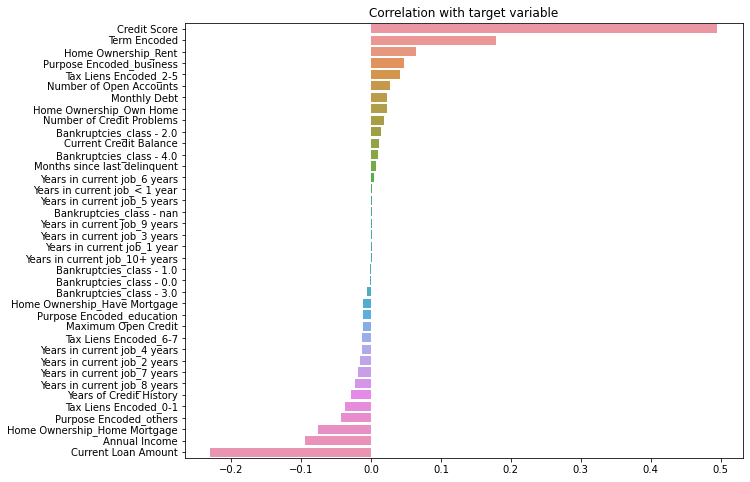

In [18]:
corr_with_target = df_train[NUM_FEATURES_NAME + CAT_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Из графика корреляции мы видим, что есть 2 совершенно бесполезных признака:
Years in current job и Bankruptcies.

Также не вносит существенного вклада и Current Credit Balance

In [19]:
# бесполезные фичи, которые исключаем из обучения
USELESS_FEATURES = [
    'Years in current job_1 year',
    'Years in current job_10+ years',
    'Years in current job_2 years',
    'Years in current job_3 years', 
    'Years in current job_4 years', 
    'Years in current job_5 years', 
    'Years in current job_6 years', 
    'Years in current job_7 years', 
    'Years in current job_8 years', 
    'Years in current job_9 years', 
    'Years in current job_< 1 year',
    'Bankruptcies_class - 0.0',
    'Bankruptcies_class - 1.0',
    'Bankruptcies_class - 2.0',
    'Bankruptcies_class - 3.0',
    'Bankruptcies_class - 4.0',
    'Bankruptcies_class - nan',
    'Current Credit Balance'
]

## 5. Отбор признаков


**Новые фичи**

* Добавим фичу "без кредитов" - отсутствие текущих кредитов
* Добавим фичу "Отношение платежа к ежемесячному доходу"
* Добавим фичу "Разность ежемесячного дохода и платежа"

In [20]:
# добавляем фичи
def addFeatures(df):
    # без кредитов
    df['New'] = 0
    df.loc[df['Maximum Open Credit']==0, 'New'] = 1
    
    # Отношение платежа к ежемесячному доходу
    df['DebtPercent'] = 12*df['Monthly Debt'] / df['Annual Income']
    
    # Разность ежемесячного дохода и платежа
    df['DebtDiff'] = df['Annual Income'] / 12 - df['Monthly Debt']
    
    return df

df_train = addFeatures(df_train)

In [21]:
# Отбор признаков
def getFeatures(df):
    df = df.copy()
    return df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES + USELESS_FEATURES)

## 6. Балансировка классов


Классы ужасно не сбалансированны, а нам важен "слабый" класс, поэтому добавим балансировку по прицнципу oversampling (undersdampling был хуже)

In [22]:
# балансировка черех overSampling
def processBalance(X_train, y_train, target_name):
    df = pd.concat([X_train, y_train], axis=1)
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
        
    X_train_balanced = df.drop(columns=target_name)
    y_train_balanced = df[target_name]
    
    return X_train_balanced, y_train_balanced

## 7. Подбор моделей, получение бейзлана


In [23]:
X_train = getFeatures(df_train)
y_train = df_train[TARGET_NAME]

X_train, y_train = processBalance(X_train, y_train, TARGET_NAME)

# создаем копию нормализованных данных
scaler = StandardScaler()
X_train_norm = X_train.copy()
X_train_norm = scaler.fit_transform(X_train_norm)

# линейные модели
model_lr = LogisticRegression()
model_lr.fit(X_train_norm, y_train)

model_lr2 = LogisticRegressionCV()
model_lr2.fit(X_train_norm, y_train)

# knn
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_norm, y_train)

# деревья
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

# Ансамбли
model_en = ExtraTreesClassifier()
model_en.fit(X_train, y_train)

model_en2 = RandomForestClassifier()
model_en2.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
# Проверяем модели
df = df_train_test.copy()
df = processNumFeatures(df)
df, newFields = processCatFeatures(df)
df = processOutlier(df)
df = processNan(df)

df = addFeatures(df)

X_test = df[getFeatures(df_train).columns]
y_test = df[TARGET_NAME]

# создаем копию нормализованных данных
scaler = StandardScaler()
X_test_norm = X_test.copy()
X_test_norm = scaler.fit_transform(X_test_norm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [25]:
evaluate_preds(model_lr, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.91      0.81      3774
           1       0.83      0.59      0.69      2952

    accuracy                           0.77      6726
   macro avg       0.79      0.75      0.75      6726
weighted avg       0.78      0.77      0.76      6726

TEST

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      1613
           1       0.47      0.78      0.59       637

    accuracy                           0.69      2250
   macro avg       0.68      0.72      0.67      2250
weighted avg       0.77      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1056  557
1                141  496


In [26]:
evaluate_preds(model_lr2, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      3774
           1       0.83      0.59      0.69      2952

    accuracy                           0.77      6726
   macro avg       0.79      0.75      0.75      6726
weighted avg       0.78      0.77      0.76      6726

TEST

              precision    recall  f1-score   support

           0       0.88      0.71      0.78      1613
           1       0.50      0.75      0.60       637

    accuracy                           0.72      2250
   macro avg       0.69      0.73      0.69      2250
weighted avg       0.77      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1138  475
1                159  478


In [27]:
evaluate_preds(model_knn, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      3774
           1       0.84      0.73      0.78      2952

    accuracy                           0.82      6726
   macro avg       0.82      0.81      0.81      6726
weighted avg       0.82      0.82      0.82      6726

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1613
           1       0.55      0.54      0.54       637

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1334  279
1                295  342


In [28]:
evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3774
           1       1.00      1.00      1.00      2952

    accuracy                           1.00      6726
   macro avg       1.00      1.00      1.00      6726
weighted avg       1.00      1.00      1.00      6726

TEST

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1613
           1       0.58      0.59      0.58       637

    accuracy                           0.76      2250
   macro avg       0.71      0.71      0.71      2250
weighted avg       0.76      0.76      0.76      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1344  269
1                264  373


In [29]:
evaluate_preds(model_en, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3774
           1       1.00      1.00      1.00      2952

    accuracy                           1.00      6726
   macro avg       1.00      1.00      1.00      6726
weighted avg       1.00      1.00      1.00      6726

TEST

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1613
           1       0.85      0.47      0.60       637

    accuracy                           0.83      2250
   macro avg       0.84      0.72      0.75      2250
weighted avg       0.83      0.83      0.81      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1560   53
1                338  299


In [30]:
evaluate_preds(model_en2, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3774
           1       1.00      1.00      1.00      2952

    accuracy                           1.00      6726
   macro avg       1.00      1.00      1.00      6726
weighted avg       1.00      1.00      1.00      6726

TEST

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1613
           1       0.83      0.52      0.64       637

    accuracy                           0.84      2250
   macro avg       0.84      0.74      0.77      2250
weighted avg       0.84      0.84      0.82      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1547   66
1                304  333


## 8. Выбор наилучшей модели, настройка гиперпараметров


Лучший результат  с параметрами по умолчанию показал случайный лес. Но при этом у него дикое переобучение.

Гораздо лучше в этом плане выглядит LogisticRegressionCV f1 score для 1-го класса в районе 0.6.

Попробуем подобрать параметры.

In [31]:
%%time

# линейные модели
model = LogisticRegressionCV(random_state=0)

param_grid=[{
             'max_iter': [5, 10, 50, 100], 
             'Cs': [1, 5, 10], 
            }]

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_norm, y_train)

Wall time: 15.8 s


GridSearchCV(cv=5, estimator=LogisticRegressionCV(random_state=0),
             param_grid=[{'Cs': [1, 5, 10], 'max_iter': [5, 10, 50, 100]}])

In [32]:
grid_search.best_params_

{'Cs': 5, 'max_iter': 5}

In [33]:
model_final = LogisticRegressionCV(random_state=0, Cs=5, max_iter=5)
model_final.fit(X_train_norm, y_train)

evaluate_preds(model_final, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      3774
           1       0.83      0.60      0.69      2952

    accuracy                           0.77      6726
   macro avg       0.79      0.75      0.75      6726
weighted avg       0.78      0.77      0.76      6726

TEST

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      1613
           1       0.49      0.76      0.60       637

    accuracy                           0.71      2250
   macro avg       0.68      0.72      0.68      2250
weighted avg       0.77      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1113  500
1                155  482


## 9. Проверка качества, борьба с переобучением


Разница train/test сократилась, но модель все еще переобучена.

Будем боросться c переобучением сокращением числа признаков.

In [34]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(model_final.coef_))], axis = 1)
coefficients

,0,0
0,Annual Income,-0.014974
1,Number of Open Accounts,-0.007163
2,Years of Credit History,-0.001826
3,Maximum Open Credit,-0.241446
4,Number of Credit Problems,0.044205
5,Months since last delinquent,-0.163522
6,Current Loan Amount,-2.293962
7,Monthly Debt,-0.407687
8,Credit Score,5.304197
9,Term Encoded,0.495595


Уберем из модели все признаки имеющие коэффициенты меньше 5/100 по модулю

In [35]:
USELESS_FEATURES = USELESS_FEATURES + [
    'Number of Open Accounts',
    'Years of Credit History',
    'Tax Liens Encoded_0-1',
    'Annual Income',
    'Number of Credit Problems',
    'Home Ownership_Own Home',
    'Home Ownership_Rent',
    'Purpose Encoded_education',
    'Tax Liens Encoded_2-5',
    'New'
]

## 10. Интерпретация результатов

In [36]:
# финальная модель

X_train = getFeatures(df_train)
y_train = df_train[TARGET_NAME]

X_train, y_train = processBalance(X_train, y_train, TARGET_NAME)

# создаем копию нормализованных данных
scaler = StandardScaler()
X_train_norm = X_train.copy()
X_train_norm = scaler.fit_transform(X_train_norm)


df = df_train_test.copy()
df = processNumFeatures(df)
df, newFields = processCatFeatures(df)
df = processOutlier(df)
df = processNan(df)

df = addFeatures(df)

X_test = df[getFeatures(df_train).columns]
y_test = df[TARGET_NAME]

# создаем копию нормализованных данных
scaler = StandardScaler()
X_test_norm = X_test.copy()
X_test_norm = scaler.fit_transform(X_test_norm)

model_final = LogisticRegressionCV(random_state=0, Cs=5, max_iter=5)
model_final.fit(X_train_norm, y_train)

evaluate_preds(model_final, X_train_norm, X_test_norm, y_train, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.91      0.81      3774
           1       0.83      0.59      0.69      2952

    accuracy                           0.77      6726
   macro avg       0.79      0.75      0.75      6726
weighted avg       0.78      0.77      0.76      6726

TEST

              precision    recall  f1-score   support

           0       0.88      0.68      0.76      1613
           1       0.48      0.76      0.59       637

    accuracy                           0.70      2250
   macro avg       0.68      0.72      0.68      2250
weighted avg       0.76      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1091  522
1                154  483


In [37]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(model_final.coef_))], axis = 1)
coefficients

,0,0
0,Maximum Open Credit,-0.292916
1,Months since last delinquent,-0.136685
2,Current Loan Amount,-2.488988
3,Monthly Debt,-0.432903
4,Credit Score,5.658639
5,Term Encoded,0.487849
6,Home Ownership_Have Mortgage,-0.081035
7,Home Ownership_Home Mortgage,-0.157365
8,Purpose Encoded_business,0.148436
9,Purpose Encoded_others,0.052365


Наиболее важным оказался признак "Credit Score", по всей видимости он аггрегирует в себе все остальные признаки.

Плохая точность предсказаний 1-го класса связана с плохой балансировкой классов.

Модель можно будет использовать лишь задав более мягкий порог отнесения к первому классу, в этом случае мы в ущерб precision получим хороший recall.

## 11. Формирование предсказания

In [38]:
df_test = df_test_orig.copy()
df_test = processNumFeatures(df_test)
df_test, newFields = processCatFeatures(df_test)
df_test = processOutlier(df_test)
df_test = processNan(df_test)
df_test = addFeatures(df_test)

# создаем копию нормализованных данных
scaler = StandardScaler()
df_test_norm = df_test.copy()
df_test_norm = df_test_norm[getFeatures(df_train).columns]
df_test_norm = scaler.fit_transform(df_test_norm)

predictions = model_final.predict(df_test_norm)

df_submit['Credit Default'] = predictions
df_submit.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


In [39]:
df_submit.to_csv('v1_submit.csv', index=False)